In [1]:
import numpy as np 
from scipy.special import erf, erfc
import matplotlib.pyplot as plt 
from scipy.integrate import trapz

In [2]:
t = np.linspace(0, 5 * 60 * 60, 10000) 
dt = t[1] - t[0]
tc = (t[1:] + t[:-1]) / 2.0 

# applied stress

In [139]:
# step function starting at 5 minutes
sigma = 1e6 *  (1 +  erf((t - 60*5)/15))/2 - 1e6 

# applied constant from 5 to 60 mins
sigma = 1e6 *  (1 +  erf((t - 60*5)/15))/2 - 1e6 *  (1 +  erf((t - 60*60)/15))/2 

# oscillatory, starting at 5 mins
omega = 0.001
sigma = (1e6 + 5e5 * np.sin(2 * np.pi * t  * omega)) *  (1 +  erf((t - 60*5)/15))/2


In [140]:

dsigma_dt = (sigma[1:] - sigma[:-1]) / dt

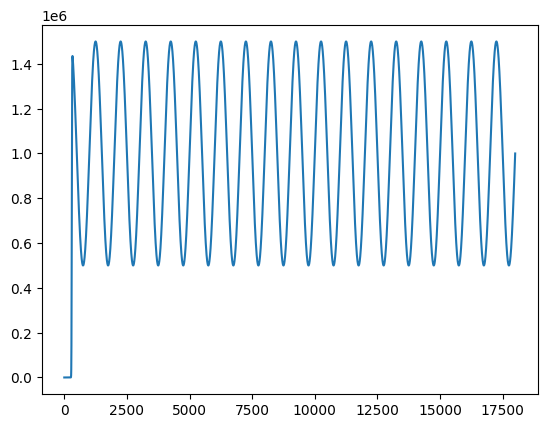

In [141]:
plt.plot(t, sigma)
# plt.xlim([0, 500])

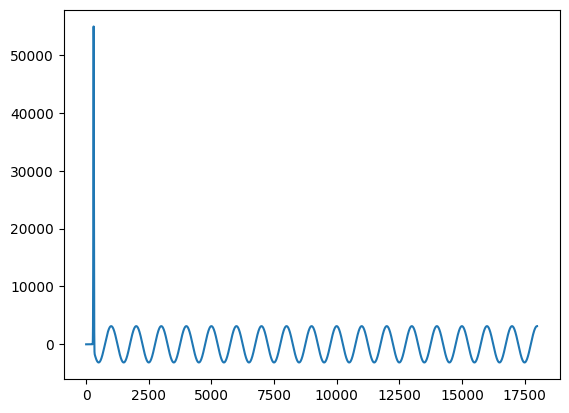

In [142]:
plt.plot(tc, dsigma_dt)
# plt.xlim([0, 500])

In [143]:
E =  1e10
eta = 2e13

In [144]:
strain = np.zeros((t.size - 1))
for i_t, t_i in enumerate(t[:-1]): 

    if i_t == 0: 
        continue 

    timerange = t[0:i_t+1]
    t_diff = t_i -timerange
    t_diff = t_diff * (t_diff > 0)

    # maxwell
    Jmax = 1/ E + t_diff / eta 
    # J = Jmax
    
    # voigt 
    trelax = eta / E 
    Jvoigt = 1/E * (1 - np.exp(-t_diff/trelax))
    J = Jvoigt
    
    # standard linear solid, Kelvin-Voigt representation 
    # J = 1/E + Jvoigt

    # burgers
    # J = Jmax + Jvoigt

    dsigma = dsigma_dt[0:i_t+1]

    integrand = J * dsigma    
    strain[i_t] = trapz(integrand, timerange)

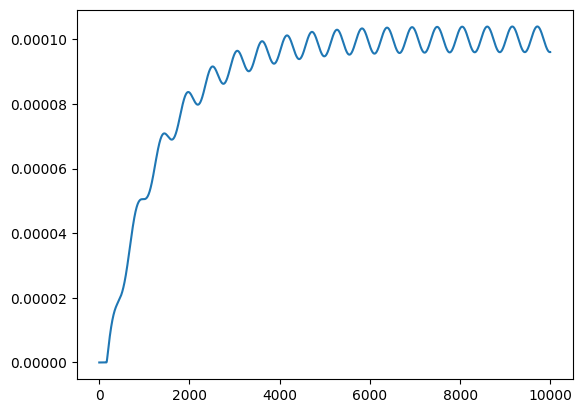

In [145]:
plt.plot(strain)
# plt.xlim([0, 1000])

In [146]:
strain.max() - strain[-1]

7.91766885233929e-06

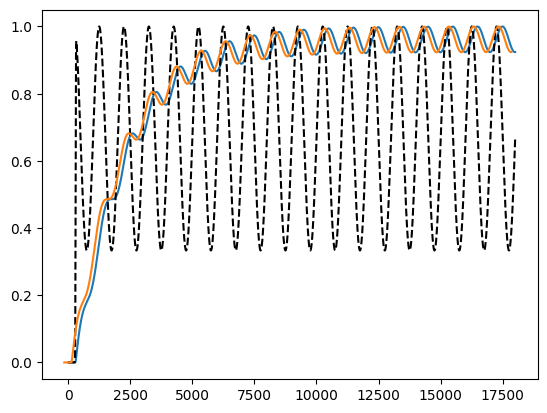

In [151]:
plt.plot(tc, strain/strain.max())
plt.plot(t, sigma/sigma.max(),'--k')
plt.plot(tc-157, strain/strain.max())

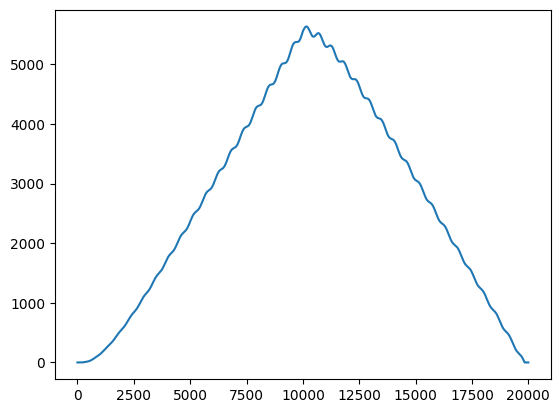

In [148]:
from scipy.signal import correlate, correlation_lags
c = correlate(strain/strain.max(), sigma/sigma.max())
lags = correlation_lags(strain.size, sigma.size)
plt.plot(c)

In [149]:
delta = lags[np.argmax(c)]
delta 

157

In [150]:
np.tan(delta)

-0.07980143414928566

In [122]:
lag

-100

# Calculating phase lag between two signals: manual correlation and FFT 

number of oscillations: 100.0


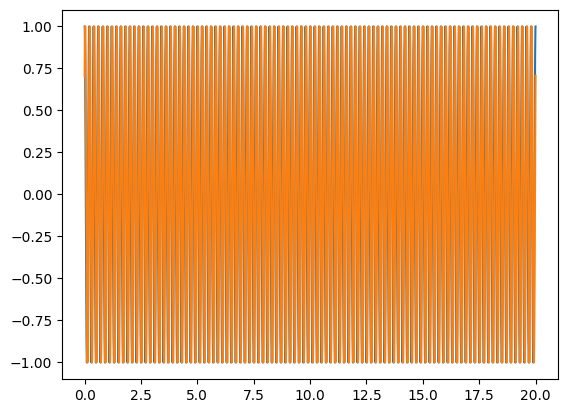

In [338]:
omega = 5
t = np.linspace(0, 20, 100000)
a = np.cos(2 * np.pi * omega * t)
actual_shift = - np.pi / 4
b = np.cos(2 * np.pi * omega * t + actual_shift)
plt.plot(t, a)
plt.plot(t, b)

print(f"number of oscillations: {t.max() * omega}")

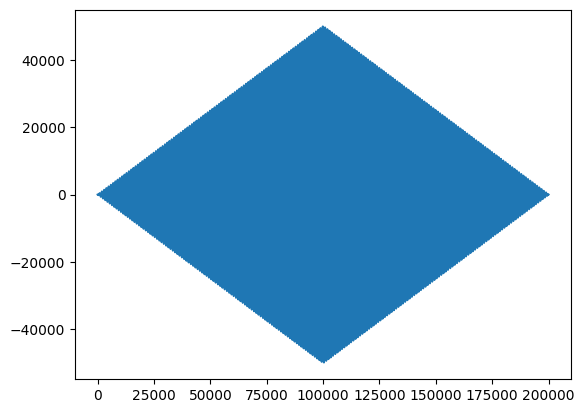

In [339]:
from scipy.signal import correlate, correlation_lags
c = correlate(a, b)
lags = correlation_lags(a.size, b.size)
plt.plot(c)

In [340]:
timeshift = lags[np.argmax(c)] / lags.max() * t[-1]
timeshift

-0.025000250002500026

In [341]:
# nsamples = a.size
# dt = np.linspace(-t[-1], t[-1], 2*nsamples-1)
# timeshift = dt[c.argmax()]
# timeshift

In [342]:
lags 

array([-99999, -99998, -99997, ...,  99997,  99998,  99999])

In [343]:
nsamples

100000

(0.0, 0.5)

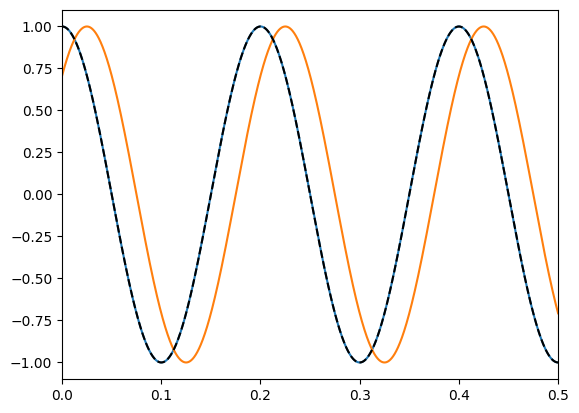

In [344]:
plt.plot(t, a)
plt.plot(t, b)
plt.plot(t+timeshift, b, '--k')
plt.xlim([0, 0.5])

In [345]:
period = 1 / omega

In [346]:
phase_shift = 2*np.pi*(((0.5 + timeshift/period) % 1.0) - 0.5)
phase_shift

-0.7854060174576228

In [347]:
actual_shift

-0.7853981633974483

In [348]:
np.abs((phase_shift - actual_shift)/actual_shift) * 100

0.0010000100000981081

In [102]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal
def correlate(f, nsamples, ncycles, phase_lag):
    # f = 5  # [Hz]
    omega = 2 * np.pi * f
    maxtime = ncycles / f
    t = np.linspace(0, maxtime, nsamples, endpoint=False)
    actual_shift = phase_lag # - np.pi / 4
        
    a = np.cos(2 * np.pi * f * t)
    b = np.cos(2 * np.pi * f * t + actual_shift)
    
    nsamples = t.size 
    c = signal.correlate(a, b)
    lags = signal.correlation_lags(a.size, b.size)
    
    timeshift = lags[np.argmax(c)] / lags.max() * t[-1]
    phase_shift = 2*np.pi*(((0.5 + timeshift * f) % 1.0) - 0.5)
    
    err = np.abs((phase_lag - phase_shift)/phase_lag)
    return a, b, t, timeshift, phase_shift, err

import scipy.fftpack
def fft_phase(f,nsamples, ncycles, phase_lag):
    
    maxtime = ncycles / f    
    t = np.linspace(0, maxtime, nsamples, endpoint=False)
    
    a = np.sin(2 * np.pi * f * t)
    b = np.sin(2 * np.pi * f * t + phase_lag)
    
    # nsamples = t.size 
    # c = signal.correlate(a, b)
    # lags = signal.correlation_lags(a.size, b.size)
    
    # timeshift = lags[np.argmax(c)] / lags.max() * t[-1]
    # phase_shift = 2*np.pi*(((0.5 + timeshift * f) % 1.0) - 0.5)

    Y = scipy.fftpack.fftshift(scipy.fftpack.fft(b))
    f = scipy.fftpack.fftshift(scipy.fftpack.fftfreq(len(b)))
    
    p = np.angle(Y)
    p[np.abs(Y) < 1] = 0

    # err = np.abs((phase_lag - phase_shift)/phase_lag)
    return f, p, p[p==p.max()]



(array([0.78539816]), 2.356194490192345)


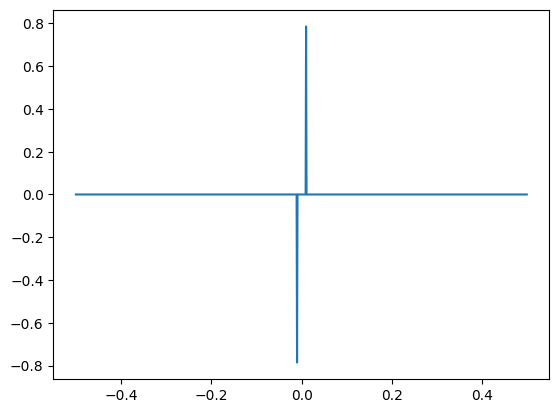

In [107]:
phase_in = 3 / 4 *  np.pi
f, p, phase = fft_phase(5, 1000, 10, phase_in)
print((phase, phase_in))
plt.plot(f, p)

In [54]:
a, b, t, timeshift, phase_shift, err = correlate(5, 1000, 10, -np.pi/4)

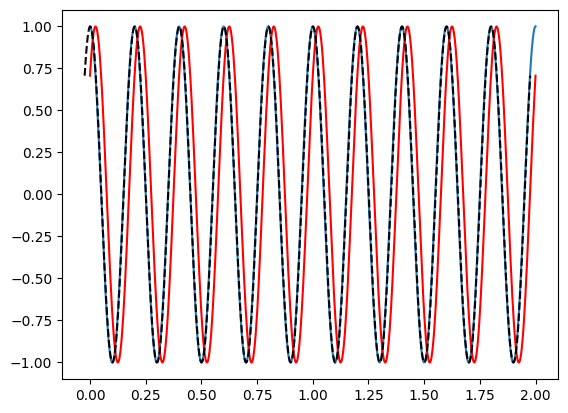

In [55]:
plt.plot(t, a)
plt.plot(t, b,'r')
plt.plot(t + timeshift, b, '--k')

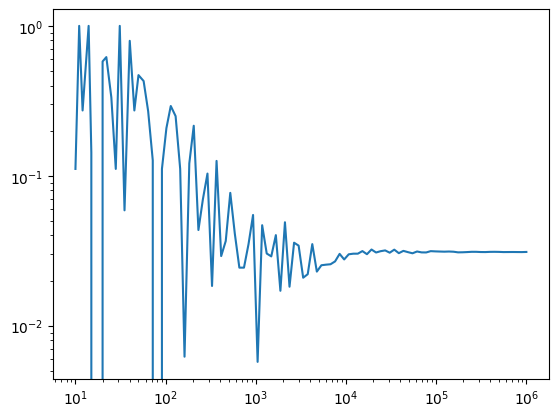

In [56]:
errs = []
nsamples_arr = np.logspace(1, 6, 100, dtype='int')
for nsamples in nsamples_arr:
    a, b, t, timeshift, phase_shift, err = correlate(5, nsamples, 10, -np.pi/4)
    errs.append(err)

plt.loglog(nsamples_arr, errs)

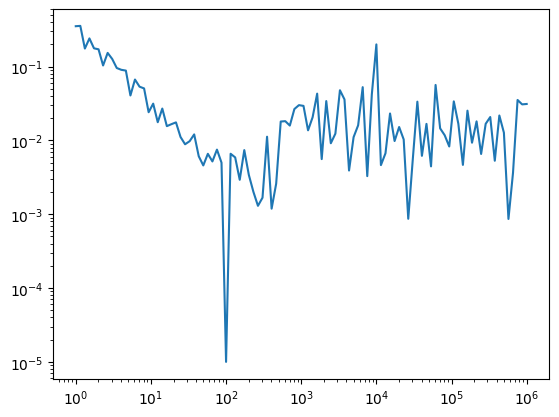

In [57]:
errs = []
ncycles = np.logspace(0, 6, 100)
for ncycle in ncycles:
    a, b, t, timeshift, phase_shift, err = correlate(5, int(1e5), ncycle, -np.pi/4)
    errs.append(err)

plt.loglog(ncycles, errs)

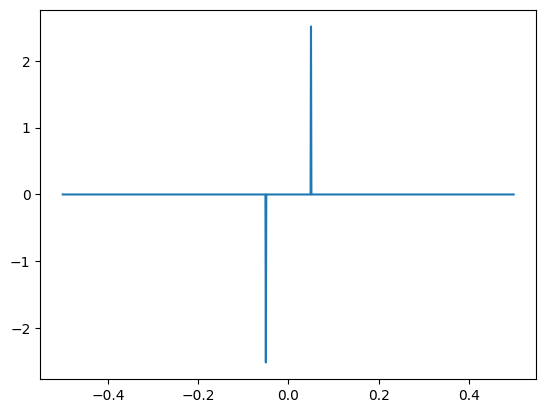

array([3.53394965e-16])

In [114]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

phase = .8 * np.pi
t = np.linspace(0, 11., 1100, endpoint=False)
y0 =np.cos(2 * np.pi * 5. * t) 
y = np.cos(2 * np.pi * 5. * t + phase)
Y = scipy.fftpack.fftshift(scipy.fftpack.fft(y))
f = scipy.fftpack.fftshift(scipy.fftpack.fftfreq(len(y)))

p = np.angle(Y)
p[np.abs(Y) < 1] = 0
plt.plot(f, p)
plt.show()
np.abs((p[p==p.max()] - phase) / phase)

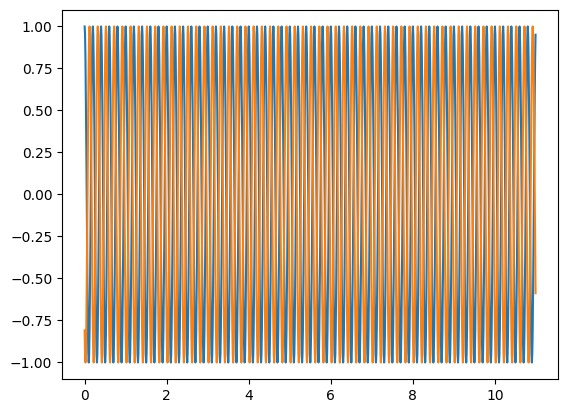

In [115]:
plt.plot(t, y0)
plt.plot(t, y)

## phase lag via paleoclim? 

Time axis values sorted in ascending order
Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='time [s]', ylabel='value'>)

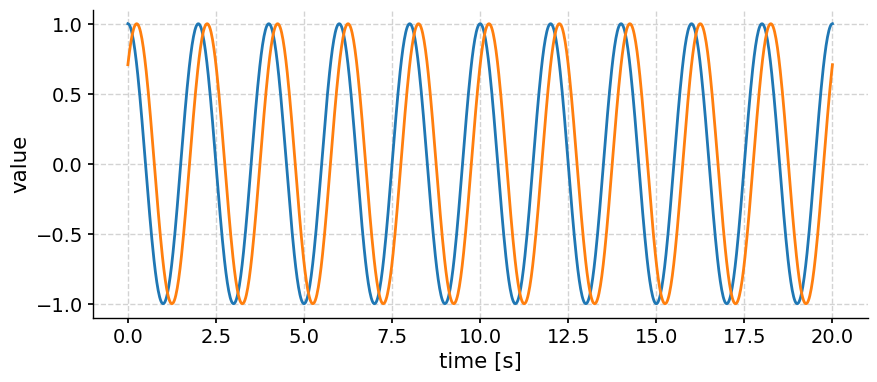

In [26]:
import pyleoclim as pyleo
import numpy as np

omega = 0.5
t = np.linspace(0, 20, 1000)
a = np.cos(2 * np.pi * omega * t)
phase_shift =  - np.pi / 4
b = np.cos(2 * np.pi * omega * t + phase_shift)

b_series = pyleo.Series(time=t, value=b,time_unit='s', value_name='b')
a_series = pyleo.Series(time=t, value=a, time_unit='s', value_name='a')
ms = pyleo.MultipleSeries([a_series,b_series])
ms.plot()

(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Scale [s]'>)

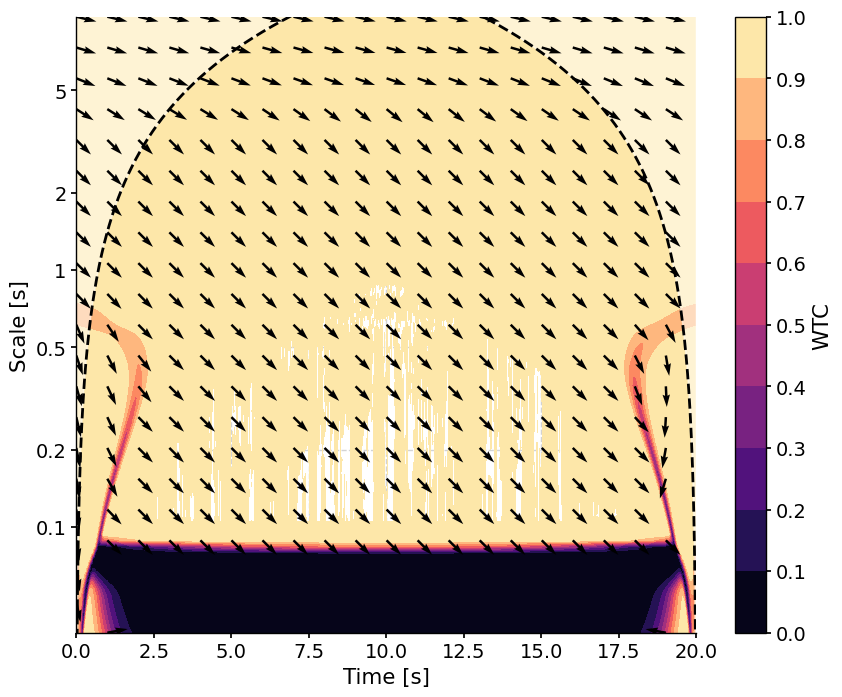

In [27]:
wve = b_series.wavelet_coherence(a_series)
wve.plot()

From Lene et al: 

> Wavelet Transform Coherence. The horizontal axis represents the time of the experimental task and the vertical axis represents the period(s) of wavelets—the intervals at which synchronicity is potentially observed

Léné, P. et al. (2020). Wavelet Transform Coherence: An Innovative Method to Investigate Social Interaction in NeuroIS. In: Davis, F., Riedl, R., vom Brocke, J., Léger, PM., Randolph, A., Fischer, T. (eds) Information Systems and Neuroscience. Lecture Notes in Information Systems and Organisation, vol 32. Springer, Cham. https://doi.org/10.1007/978-3-030-28144-1_16

At scales < 1, we're at less than a full wavelength, the transform struggles a bit (missing data), and at 0.1, it's much less than a wavelength, so we get no correlation at all.

Since we know our applied period, let's evaluate the phase lag at that exact period: 

In [33]:
ps = wve.phase_stats([1 / omega])
ps

Results(mean_angle=-0.7849042033242344, kappa=2074780.8651062846, sigma=0.0006942468779157535, kappa_hi=2243274.654742939, sigma_lo=0.0006676653279114395)

In [34]:
ps.mean_angle

-0.7849042033242344

In [35]:
np.abs((ps.mean_angle - phase_shift)/phase_shift)

0.0006289294987362072

Time axis values sorted in ascending order
Time axis values sorted in ascending order


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Scale [s]'>)

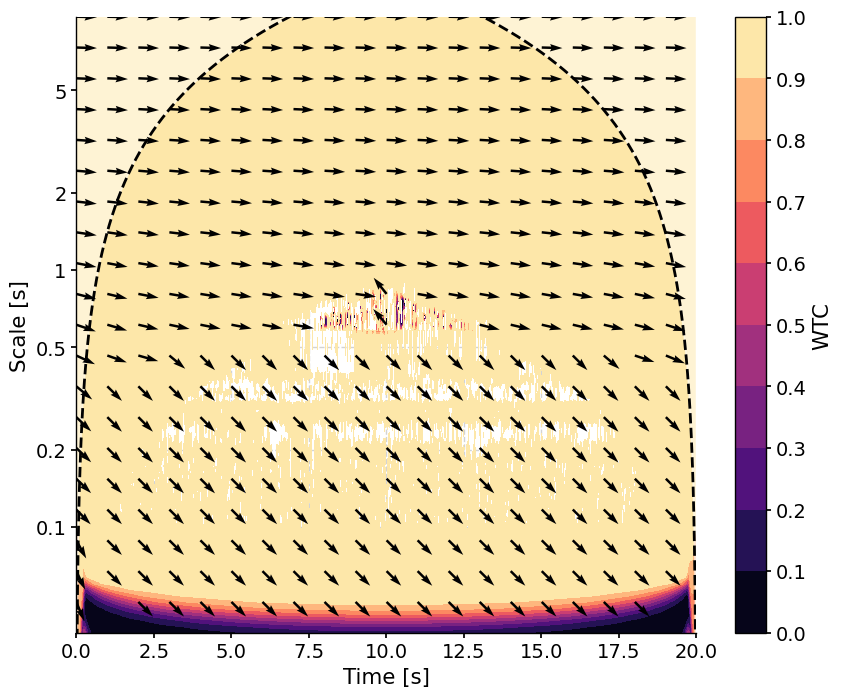

In [40]:
import pyleoclim as pyleo
import numpy as np

freq = 5
omega = 2 * np.pi * freq
t = np.linspace(0, 20, 1000)
a = np.cos(omega * t)
phase_shift =  - np.pi / 4
b = np.cos(omega* t + phase_shift)

b_series = pyleo.Series(time=t, value=b,time_unit='s', value_name='b')
a_series = pyleo.Series(time=t, value=a, time_unit='s', value_name='a')
ms = pyleo.MultipleSeries([a_series,b_series])
wve = b_series.wavelet_coherence(a_series)
wve.plot()

In [44]:
ps = wve.phase_stats([1 / freq])
ps

Results(mean_angle=-0.7848850644459321, kappa=139775.00231940355, sigma=0.0026747674081542567, kappa_hi=150132.35966770264, sigma_lo=0.00258085479752376)

In [45]:
np.abs((ps.mean_angle - phase_shift)/phase_shift)

0.0006532978754325616

In [46]:
1/freq 

0.2

(-2.5004564248451886, -2.5132741228718345, 0.005099999999999817)


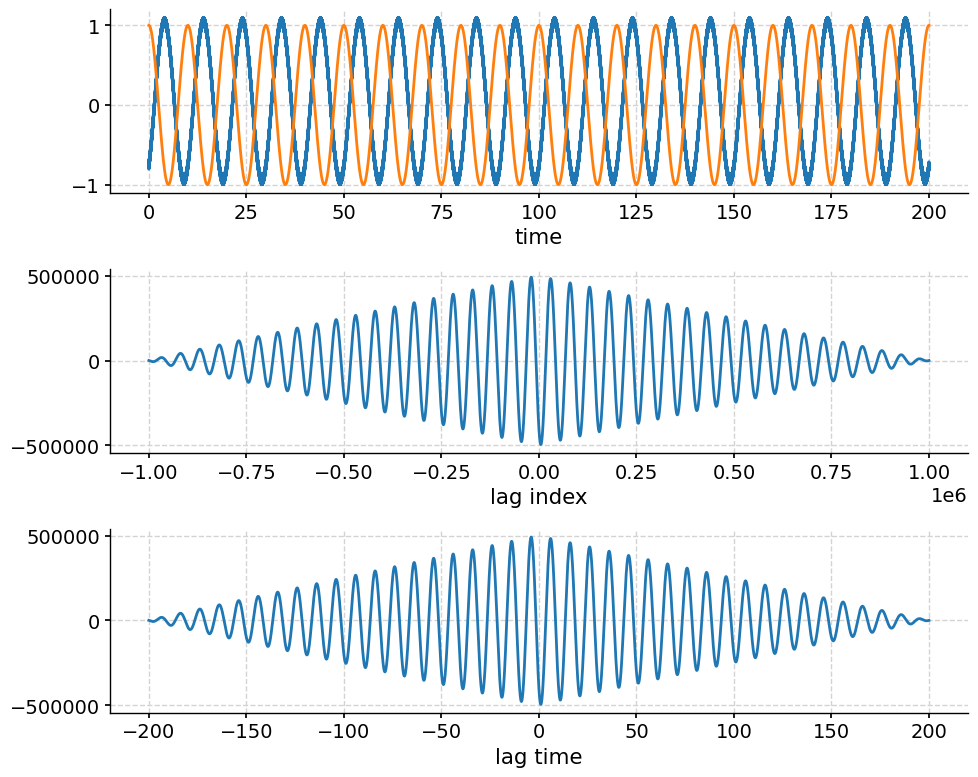

In [89]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

f = 0.1  # [Hz]
ncycles = 20
nsamples = int(1e6)
phase_lag = - .8 * np.pi 
maxtime = 200 # ncycles / f

t = np.linspace(0, maxtime, nsamples, endpoint=False)
dt = t[1] - t[0]
a = np.cos(2 * np.pi * f * t)
b = np.cos(2 * np.pi * f * t + phase_lag) + np.random.random(t.shape) * 0.1

nsamples = t.size 
c = signal.correlate(a, b)
lags = signal.correlation_lags(a.size, b.size)
lags_time = lags * dt 
timeshift = lags[np.argmax(c)] / lags.max() * t[-1]

phase_shift = 2*np.pi* f * timeshift

err = np.abs((phase_lag - phase_shift)/phase_lag)
print((phase_shift, phase_lag, err))

f, axs = plt.subplots(nrows =3 , ncols = 1, figsize=(10,8))

axs[0].plot(t, b)
axs[0].plot(t, a)
axs[0].set_xlabel('time')
axs[1].plot(lags, c) 
axs[1].set_xlabel("lag index") 

axs[2].plot(lags_time, c)
axs[2].set_xlabel("lag time") 

f.set_tight_layout('tight')

(0.0, 0.1)

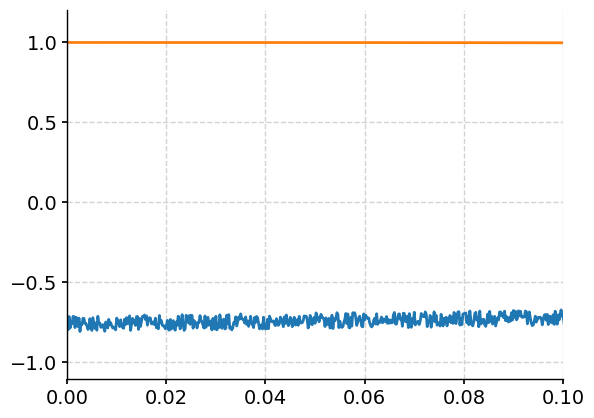

In [93]:
plt.plot(t, b)
plt.plot(t, a)
plt.xlim([0, 0.1])

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy 

f = 0.1  # [Hz]
ncycles = 20
nsamples = int(1e6)
phase_lag = -  np.pi  / 2
maxtime = 200 # ncycles / f

t = np.linspace(0, maxtime, nsamples, endpoint=False)

a = np.cos(2 * np.pi * f * t)
b = np.cos(2 * np.pi * f * t + phase_lag)

b_fft = scipy.fftpack.fft(b)
b_fftfreq = scipy.fftpack.fftfreq(len(b))
Y = scipy.fftpack.fftshift(b)
f = scipy.fftpack.fftshift(b_fftfreq)
P = np.angle(Y)

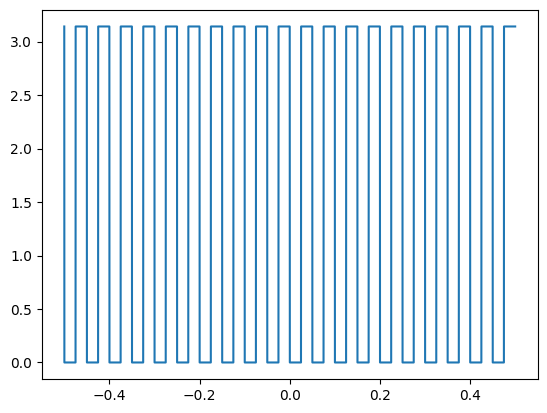

In [12]:
plt.plot(f, P)

In [13]:
P[P==P.max()]

array([3.14159265, 3.14159265, 3.14159265, ..., 3.14159265, 3.14159265,
       3.14159265])